### Import chipwhisperer and set the scope

The scope can be left as is, because we have only one device connected. In cases where there are multiple divices connected we can use `scope(sn=DEVICE_SERIAL_NUMBER)` to create scope for a specific device. 

In [1]:
import chipwhisperer as cw

In [2]:
scope = cw.scope()

Note to self:
When the scope is created, the device's green LED light starts blinking (on top of the blue LED that probably indicates that the device is connected physically).

We also set the scope to a default setup which means:

- Sets the scope gain to 45dB
- Sets the scope to capture 5000 samples
- Sets the scope offset to 0 (aka it will begin capturing as soon as it is triggered)
- Sets the scope trigger to rising edge
- Outputs a 7.37MHz clock to the target on HS2
- Clocks the scope ADC at 4*7.37MHz. Note that this is synchronous to the target clock on HS2
- Assigns GPIO1 as serial RX
- Assigns GPIO2 as serial TX

In [3]:
scope.default_setup()

### Connecting to target

Now we can connect to the target (probably meaning the target board). 

In [4]:
target = cw.target(scope, cw.targets.SimpleSerial2) #cw.targets.SimpleSerial can be omitted
#MY CHANGES - changed target to SimpleSerial2 - to be able to send_cmd

In [5]:
%%bash
cd version_02/
make PLATFORM='CWLITEARM' CRYPTO_TARGET=NONE

SS_VER set to SS_VER_2_1
rm -f -- simpleserial-target-CWLITEARM.hex
rm -f -- simpleserial-target-CWLITEARM.eep
rm -f -- simpleserial-target-CWLITEARM.cof
rm -f -- simpleserial-target-CWLITEARM.elf
rm -f -- simpleserial-target-CWLITEARM.map
rm -f -- simpleserial-target-CWLITEARM.sym
rm -f -- simpleserial-target-CWLITEARM.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- main.s network.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- main.d network.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- main.i network.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (GNU Arm Embedded Toolchain 10-2020-q4-major) 10.2.1 20201103 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOS

In file included from main.c:16:
network_config.h:15:6: warning: function declaration isn't a prototype [-Wstrict-prototypes]
   15 | void init_weights() {
      |      ^~~~~~~~~~~~


.
Compiling C: network.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_2_1 -DSTM32F303xC -DSTM32F3 -DSTM32 -DDEBUG -DHAL_TYPE=HAL_stm32f3 -DPLATFORM=CWLITEARM -DF_CPU=7372800UL -DSS_VER_2_0=2 -DSS_VER_1_1=1 -DSS_VER_1_0=0 -Os -funsigned-char -funsigned-bitfields -fshort-enums -Wall -Wstrict-prototypes -Wa,-adhlns=objdir/network.lst -I./simpleserial/ -I./hal -I./hal/stm32f3 -I./hal/stm32f3/CMSIS -I./hal/stm32f3/CMSIS/core -I./hal/stm32f3/CMSIS/device -I./hal/stm32f4/Legacy -std=gnu99  -MMD -MP -MF .dep/network.o.d network.c -o objdir/network.o
.
Compiling C: ./simpleserial/simpleserial.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_2_1 -DSTM32F303xC -DSTM32F3 -DSTM32 -DDEBUG -DHAL_TYPE=HAL_stm32f3 -DPLATFORM=CWLITEARM -DF_CPU=7372800UL -DSS_VER_2_0=2 -DSS_VER_1_1=1 -DSS_VER_1_0=0 -Os -funsigned-char -funsigned-bitfield

### Flashing The Compiled .hex Onto Target

In [6]:
cw.program_target(scope, cw.programmers.STM32FProgrammer, "version_01/simpleserial-target-CWLITEARM.hex")

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 16239 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 16239 bytes


### Capturing a trace

In [7]:
# arm the scope
scope.arm()

# Set the maximum number of points in a trace
scope.adc.fifo_fill_mode = "normal"
scope.adc.samples = 24431
scope.adc.decimate = 2


# flush the UART buffer
target.flush()

data = bytearray([0x42] * 16)

#target.simpleserial_write('p', data)
target.send_cmd('p', 0x80, data)

ret = scope.capture()
trace = scope.get_last_trace()

returned_data = target.read_cmd('r')
print(returned_data)
ack = target.read_cmd('e')
print(ack)
print(len(trace))

CWbytearray(b'00 72 10 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 8d 00')
CWbytearray(b'00 65 01 00 eb 00')
24431


In [50]:
print(target.get_simpleserial_commands())

[{'cmd': b'v', 'len': 0, 'flags': 0}, {'cmd': b'w', 'len': 0, 'flags': 0}, {'cmd': b'p', 'len': 0, 'flags': 0}, {'cmd': b'x', 'len': 0, 'flags': 0}]


In [52]:
target.send_cmd('x', 0x80, data)
returned_data = target.read_cmd('r')

print(returned_data)


CWbytearray(b'00 72 10 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 8d 00')


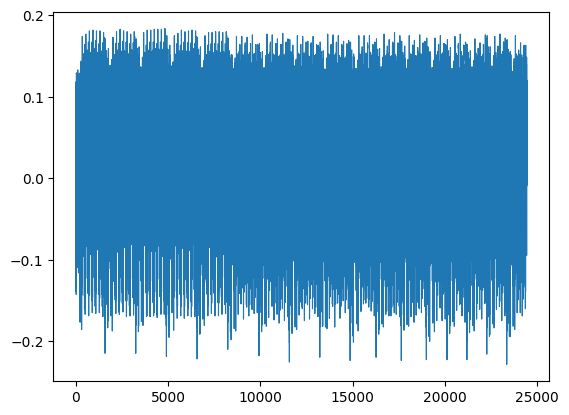

In [8]:
import matplotlib.pyplot as plt
# Plot the trace
plt.plot(trace, linewidth=0.8)

#plt.savefig('figure.svg', format='svg')
plt.show()

In [10]:
print(trace)
print(len(trace))

[-0.00097656  0.01464844 -0.10644531 ...  0.12011719  0.06835938
 -0.00683594]
24431


In [ ]:
print(returned_data)
byte_arr = bytearray(returned_data)
print(byte_arr)


### Trying Segmented Capture

In [ ]:
scope.arm()
scope.adc.fifo_fill_mode = "segment"
scope.adc.samples = 21000
# flush the UART buffer
target.flush()

data = bytearray([0x42] * 16)
target.send_cmd('p', 0x80, data)
traces = []

ret = scope.capture_segmented()
trace = scope.get_last_trace_segmented()

total_trace = []
print(len(trace))
for t in trace:
    print(len(t))
    for p in t:
        total_trace.append(p)
        
ret = scope.capture_segmented()
trace = scope.get_last_trace_segmented()

print(len(trace))
for t in trace:
    print(len(t))
    for p in t:
        total_trace.append(p)
    
#while captured_points < total_points:
#        
#    ret = scope.capture_segmented()
#    trace = scope.get_last_trace_segmented()
#    
#    traces.append(trace)
#    print(len(trace))
#    captured_points += len(trace)

In [ ]:
plt.plot(total_trace, linewidth=0.8)

plt.savefig('figure_segmented.svg', format='svg')
plt.show()

### Disconnecting the target and the scope

In [ ]:
target.dis()

In [ ]:
scope.dis()